In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name

    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')


    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [2]:
import torch
print(torch.cuda.is_available())         # Should be True
print(torch.cuda.device_count())         # Should be > 0
print(torch.cuda.current_device())       # Should not throw
print(torch.cuda.get_device_name(0))     # Should print your GPU


True
1
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [5]:
class Noise:
    def __init__(self, mean=0, std=0.05, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p
    
    def __call__(self, tensor):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(tensor) * self.std + self.mean
            return torch.clamp(tensor + noise, 0, 1)
        return tensor


In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    Noise(std=0.12, p=0.9),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.3, 1.2))
    ], p=0.6),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=3)  # Very small rotation for letters
    ], p=0.4),
    transforms.RandomApply([
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3))
    ], p=0.3),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
full_data = VowelConsonantDataset("/home/sampadram/Sampadram/Others/DL/Contests_Capstone/train", train=True, transform=None)

train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size
train_data, validation_data = random_split(full_data, [train_size, test_size])

train_data.dataset.transform = train_transform
validation_data.dataset.transform = val_transform

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=False)


In [8]:
test_data = VowelConsonantDataset("/home/sampadram/Sampadram/Others/DL/Contests_Capstone/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

# A look at the data

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(images.shape)
print(images[1].shape)
print(labels.shape)
print(labels[1])

torch.Size([60, 3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([60, 2, 10])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


In [10]:
def imgshow(img, title):
  npimg = img.numpy()
  # plt.figure(figsize = (60, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [11]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imgshow(img, title=[_])


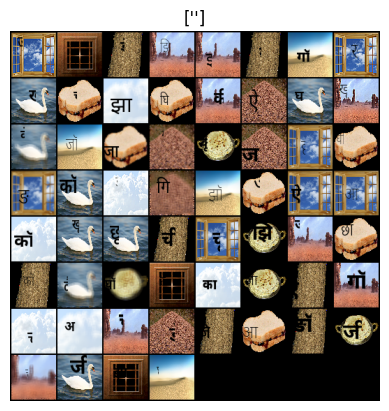

In [12]:
show_batch_images(train_loader)

# Creating the CNN architecture -  A start, Single Convolutional layer

In [ ]:
import torch.nn as nn

In [ ]:
class SingleLayer(nn.Module):
  def __init__(self):
    super(SingleLayer, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=(1, 1), stride= (2, 2))

  def forward(self, x):
    x = self.conv1(x)
    return x

In [ ]:
net = SingleLayer()

In [ ]:
out = net(images)

In [ ]:
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.show()

# Deep Convolutional Layer

In [ ]:
class DeepCNN(nn.Module):
  def __init__(self):
    super(DeepCNN, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3, 32, 5, padding=(0, 0), stride=(1, 1)), # (N, 3, 64, 64) --> (N, 32, 60, 60)\
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2), # (N, 32, 60, 60) --> (N, 32, 30, 30)
        nn.Conv2d(32, 32, 2, padding=(0, 0), stride=(2, 2)), # (N, 32, 30, 30) --> (N, 32, 15, 15)
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2) # (N, 32, 15, 15) --> (N, 32, 7, 7)
    )
    self.ffnn1 = nn.Sequential(
        nn.Linear(1568, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Added Dropout
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Added Dropout
        nn.Linear(64, 10)
    )
    self.ffnn2 = nn.Sequential(
        nn.Linear(1568, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Added Dropout
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Added Dropout
        nn.Linear(64, 10)
    )

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x1 = self.ffnn1(x)
    x2 = self.ffnn2(x)
    x = torch.stack([x1, x2], dim=1)
    return x

In [ ]:
dnet = DeepCNN()

In [ ]:
out = dnet(images)
print(out.shape)

In [ ]:
# plt.imshow(out[0, 0, :, :].detach().numpy())
# plt.show()

In [ ]:
print(out)

In [ ]:
print(out.shape)

In [ ]:
predicted = torch.argmax(out, dim=2)
true_labels = torch.argmax(labels, dim=2)

In [ ]:
print(predicted.shape)
print(true_labels.shape)

In [ ]:
correct = 0
total = 0
for i in range(out.shape[0]):
  if true_labels[i][0] == predicted[i][0] and true_labels[i][1] == predicted[i][1]:
    correct += 1
  total += 1
print(correct/total)

In [ ]:
def evaluation(predicted, true_labels):
  correct = 0
  total = 0
  # Iterate through each sample in the batch
  for i in range(predicted.shape[0]):
    # Check if both vowel and consonant predictions are correct
    if true_labels[i][0] == predicted[i][0] and true_labels[i][1] == predicted[i][1]:
      correct += 1
    total += 1
  return correct/total

In [ ]:
acc = evaluation(predicted, true_labels)
print(acc)

# Training

In [18]:
from tqdm.notebook import tqdm

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
dnet.to(device)

In [ ]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(dnet.parameters(), lr=0.05, weight_decay=1e-5) # Added weight_decay

In [ ]:
def evaluate_full_dataset(dataloader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=2)
        true_labels = torch.argmax(labels, dim=2)
        for i in range(predicted.shape[0]):
          if predicted[i][0] == true_labels[i][0] and predicted[i][1] == true_labels[i][1]:
            correct += 1
          total += 1
    return correct / total if total > 0 else 0


In [ ]:
loss_arr = []
loss_epoch_arr = []
max_epochs = 10
val_accuracy_arr = []

# Move model to device before training
dnet.to(device)

for epoch in tqdm(range(max_epochs), unit='epochs'):
    dnet.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()

        outputs = dnet(inputs)

        loss1 = loss_fn(outputs[:, 0, :], torch.argmax(labels[:, 0, :], dim=1)) # Loss for vowel
        loss2 = loss_fn(outputs[:, 1, :], torch.argmax(labels[:, 1, :], dim=1)) # Loss for consonant
        loss = loss1 + loss2

        loss.backward()
        opt.step()

        loss_arr.append(loss.item())
    dnet.eval()
    val_acc = evaluate_full_dataset(validation_loader, dnet)
    val_accuracy_arr.append(val_acc)
    loss_epoch_arr.append(loss.item())
    print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:.4f}')


In [ ]:
# def evaluation(net, images, labels):
#   # Move inputs to the device the model is on
#   images, labels = images.to(device), labels.to(device)
#   out = dnet(images)
#   predicted = torch.argmax(out, dim=2)
#   true_labels = torch.argmax(labels, dim=2)

#   correct = 0
#   total = 0

#   predicted, true_labels = predicted.to(device), true_labels.to(device)
#   # Iterate through each sample in the batch
#   for i in range(predicted.shape[0]):
#     # Check if both vowel and consonant predictions are correct
#     if true_labels[i][0] == predicted[i][0] and true_labels[i][1] == predicted[i][1]:
#       correct += 1
#     total += 1
#   return correct/total

In [ ]:
train_accuracy = evaluate_full_dataset(train_loader, dnet)
print(train_accuracy)

val_accuracy = evaluate_full_dataset(validation_loader, dnet)
print(val_accuracy)

# Using a pre Trained model

In [13]:
from torchvision import models

In [14]:
resnet = models.resnet18(pretrained = True)

/home/sampadram/miniconda3/envs/pip-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sampadram/miniconda3/envs/pip-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(resnet)

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [19]:
class ResNetWithTwoHeads(nn.Module):
    def __init__(self, resnet_base, num_vowel_classes=10, num_consonant_classes=10):
        super().__init__()
        self.resnet_base = resnet_base
        # self.vowel_fc = vowel_fc_layer
        # in_features = resnet_base.fc.in_features


        if hasattr(resnet_base.fc, 'in_features'):
            in_features = resnet_base.fc.in_features
        else:
            # If FC layer is already replaced, use standard ResNet dimensions
            in_features = 512
        # self.consonant_fc = consonant_fc_layer
        self.resnet_base.fc = nn.Identity()
        self.dropout = nn.Dropout(0.5)

        self.vowel_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_vowel_classes)
        )

        self.consonant_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_consonant_classes)
        )


    

    def forward(self, x):
        features = self.resnet_base(x)
        # Ensure features are flattened before passing to the linear layers
        features = features.view(features.size(0), -1)
        features = self.dropout(features)
        vowel_output = self.vowel_fc(features)
        consonant_output = self.consonant_fc(features)
        output = torch.stack([vowel_output, consonant_output], dim=1)
        return output


pretrained_model = ResNetWithTwoHeads(resnet)

pretrained_model.to(device)


ResNetWithTwoHeads(
  (resnet_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [20]:
def selective_unfreeze(model, num_layers_unfreeze = 2):
    for param in model.resnet_base.parameters():
        param.requires_grad = False
    

    layers = list(model.resnet_base.children())
    for layer in layers[-num_layers_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

    for param in model.vowel_fc.parameters():
        param.requires_grad = True
    for param in model.consonant_fc.parameters():
        param.requires_grad = True

In [21]:
def evaluate_full_dataset(dataloader, model, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=2)
        true_labels = torch.argmax(labels, dim=2)
        for i in range(predicted.shape[0]):
          if predicted[i][0] == true_labels[i][0] and predicted[i][1] == true_labels[i][1]:
            correct += 1
          total += 1
    return correct / total if total > 0 else 0


In [22]:
def train_model_new(model, train_loader, validation_loader, device, max_epochs=50):
    loss_fn = nn.CrossEntropyLoss()


    for param in model.parameters():
        param.requires_grad = True

    
    # trainable_params = list(model.vowel_fc.parameters()) + list(model.consonant_fc.parameters())
    # optim1 = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-4)
    # scheduler1 = ReduceLROnPlateau(optim1, mode='max', verbose=True, patience=5)


    # best_val_acc = 0
    # patience_counter = 0
    # early_stopping_patience = 12


    # # Training the FC models.
    # for epoch in tqdm(range(max_epochs), unit="epochs"):
    #     model.train()
    #     total_loss = 0
    #     num_batches = 0

    #     for inputs, labels in train_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = model(inputs)
    #         optim1.zero_grad()

    #         loss1 = loss_fn(outputs[:, 0, :], torch.argmax(labels[:, 0, :], dim=1))
    #         loss2 = loss_fn(outputs[:, 1, :], torch.argmax(labels[:, 1, :], dim=1))

    #         loss = loss1+loss2

    #         loss.backward()
    #         optim1.step()

    #         total_loss += loss.item()
    #         num_batches += 1
        
    #     val_acc = evaluate_full_dataset(validation_loader, model, device)
    #     avg_loss = total_loss/num_batches

    #     print(f"Epoch: {epoch}, Training Loss: {avg_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    #     scheduler1.step(val_acc)
    #     if val_acc > best_val_acc:
    #         best_val_acc = val_acc
    #         patience_counter = 0
    #         torch.save(model.state_dict(), 'best_model_stage1.pth')
    #     else:
    #         patience_counter+=1    

    #         if patience_counter >= early_stopping_patience:
    #             print(f"early stopping at epoch {epoch}")
    #             break
    
    # # Fine tune the entire model.
    # model.load_state_dict(torch.load('best_model_stage1.pth'))
    # selective_unfreeze(model, num_layers_unfreeze= 5)    
    
    # optim2 = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    # scheduler2 = ReduceLROnPlateau(optim2, mode='max', factor=0.5, patience=8, verbose=True)

    # Separate backbone and head parameters
    backbone_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'vowel_fc' in name or 'consonant_fc' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.Adam([
        {'params': backbone_params, 'lr': 5e-5, 'weight_decay': 1e-4},    # Lower LR for pre-trained features
        {'params': head_params, 'lr': 2e-4, 'weight_decay': 1e-4}         # Higher LR for classification heads
    ])
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=4, verbose=True)

    
    best_val_acc = 0
    patience_counter = 0
    early_stopping_patience = 5
    
    for epoch in tqdm(range(50), unit="epochs"):  # Stage 2: 50 epochs
        model.train()
        total_loss = 0
        num_batches = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss1 = loss_fn(outputs[:, 0, :], torch.argmax(labels[:, 0, :], dim=1))
            loss2 = loss_fn(outputs[:, 1, :], torch.argmax(labels[:, 1, :], dim=1))
            loss = loss1 + loss2
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        # Validation
        val_acc = evaluate_full_dataset(validation_loader, model, device)
        avg_loss = total_loss / num_batches
        
        print(f'Stage 2 - Epoch {epoch+1}: Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_final.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break   

    model.load_state_dict(torch.load('best_model_final.pth'))
    return model
    


In [23]:
model = ResNetWithTwoHeads(resnet, num_vowel_classes=10, num_consonant_classes=10)
model.to(device)

ResNetWithTwoHeads(
  (resnet_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [24]:
trained_model = train_model_new(model, train_loader, validation_loader, device, 100)

/home/sampadram/miniconda3/envs/pip-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?epochs/s]

Stage 2 - Epoch 1: Loss: 4.7021, Val Acc: 0.0420
Stage 2 - Epoch 2: Loss: 4.1846, Val Acc: 0.0750
Stage 2 - Epoch 3: Loss: 3.6567, Val Acc: 0.1290
Stage 2 - Epoch 4: Loss: 3.1790, Val Acc: 0.2170
Stage 2 - Epoch 5: Loss: 2.7256, Val Acc: 0.3260
Stage 2 - Epoch 6: Loss: 2.3391, Val Acc: 0.3770
Stage 2 - Epoch 7: Loss: 2.0201, Val Acc: 0.4380
Stage 2 - Epoch 8: Loss: 1.7932, Val Acc: 0.4640
Stage 2 - Epoch 9: Loss: 1.5900, Val Acc: 0.4930
Stage 2 - Epoch 10: Loss: 1.4069, Val Acc: 0.5060
Stage 2 - Epoch 11: Loss: 1.2868, Val Acc: 0.5190
Stage 2 - Epoch 12: Loss: 1.1625, Val Acc: 0.5270
Stage 2 - Epoch 13: Loss: 1.0641, Val Acc: 0.5430
Stage 2 - Epoch 14: Loss: 0.9947, Val Acc: 0.5500
Stage 2 - Epoch 15: Loss: 0.9029, Val Acc: 0.5660
Stage 2 - Epoch 16: Loss: 0.8401, Val Acc: 0.5660
Stage 2 - Epoch 17: Loss: 0.7863, Val Acc: 0.5550
Stage 2 - Epoch 18: Loss: 0.7552, Val Acc: 0.5710
Stage 2 - Epoch 19: Loss: 0.6753, Val Acc: 0.5660
Stage 2 - Epoch 20: Loss: 0.6343, Val Acc: 0.5690
Stage 2 -

In [ ]:
final_val_acc = evaluate_full_dataset(validation_loader, trained_model, device)
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

final_train_acc = evaluate_full_dataset(train_loader, trained_model, device)
print(f"Final Training Accuracy: {final_train_acc:.4f}")

In [ ]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
# Create a new optimizer for the pretrained model, training only the new layers
# Get parameters of the new layers (vowel_fc and consonant_fc)
new_layers_params = list(pretrained_model.vowel_fc.parameters()) + list(pretrained_model.consonant_fc.parameters())

opt_pretrained = optim.Adam(new_layers_params, lr=0.0005, weight_decay=1e-5) # Using the same learning rate and weight decay as before

In [ ]:
loss_arr_pretrained = []
loss_epoch_arr_pretrained = []
val_accuracy_arr_pretrained = []  # Removed validation accuracies
max_epochs = 500

# Move model to device before training
pretrained_model.to(device)

for epoch in tqdm(range(max_epochs), unit='epochs'):
    pretrained_model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt_pretrained.zero_grad()

        # Use the pretrained model
        outputs = pretrained_model(inputs)

        loss1 = loss_fn(outputs[:, 0, :], torch.argmax(labels[:, 0, :], dim=1)) # Loss for vowel
        loss2 = loss_fn(outputs[:, 1, :], torch.argmax(labels[:, 1, :], dim=1)) # Loss for consonant
        loss = loss1 + loss2

        loss.backward()
        opt_pretrained.step()

        loss_arr_pretrained.append(loss.item())
    pretrained_model.eval()
    validation_acc = evaluate_full_dataset(validation_loader, pretrained_model)
    val_accuracy_arr_pretrained.append(validation_acc)
    loss_epoch_arr_pretrained.append(loss.item())
    print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}, Validation Accuracy: {validation_acc:.4f}')

    # Removed evaluation on validation set after each epoch
    # pretrained_model.eval()  # Set model to evaluation mode
    # correct_val = 0
    # total_val = 0
    # with torch.no_grad():  # No gradient calculation during evaluation
    #     for inputs_val, labels_val in validation_loader:
    #         inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
    #         # Use the pretrained model for evaluation
    #         outputs_val = pretrained_model(inputs_val)
    #         predicted_val = torch.argmax(outputs_val, dim=2)
    #         true_labels_val = torch.argmax(labels_val, dim=2)

    #         for j in range(predicted_val.shape[0]):
    #             if true_labels_val[j][0] == predicted_val[j][0] and true_labels_val[j][1] == predicted_val[j][1]:
    #                 correct_val += 1
    #             total_val += 1

    # accuracy_val = correct_val / total_val if total_val > 0 else 0
    # val_accuracy_arr_pretrained.append(accuracy_val)
    # print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy_val:.4f}')

In [ ]:
train_accuracy = evaluate_full_dataset(train_loader, pretrained_model)
print(train_accuracy)

val_accuracy = evaluate_full_dataset(validation_loader, pretrained_model)
print(val_accuracy)